In [1]:
import os
import numpy as np
import cv2 as cv

In [2]:
path = 'E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/datasets/Architectural Heritage Elements/Architectural_Heritage_Elements_Dataset_128_Classes/'

In [3]:
classes = {'altar':0, 'apse':1, 'bell_tower':2, 'column':3, 'dome(inner)':4, 'dome(outer)':5, 'flying_buttress':6, 'gargoyle':7,
           'stained_glass':8, 'vault':9}

In [4]:
images = []
labels = []

def load_data(path):
    
    for folders in os.listdir(path):
        for files in os.listdir(path + folders + '/'):
            image = cv.imread(path + folders + '/' + files)
            if image is None:
                continue
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            image = cv.resize(image, (128, 128))
            image = image.astype('float32')/255.0
            label = classes[folders]
            images.append(image)
            labels.append(label)
    images_r = np.array(images)
    labels_r = np.array(labels)
    return images_r, labels_r

In [5]:
images, labels = load_data(path)

In [6]:
images.shape, labels.shape

((10235, 128, 128, 3), (10235,))

0


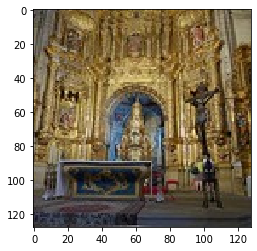

In [7]:
import matplotlib.pyplot as plt

print(labels[0])
plt.imshow(images[0])

1


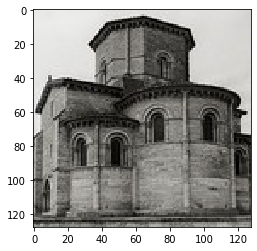

In [8]:
print(labels[900])
plt.imshow(images[900])

2


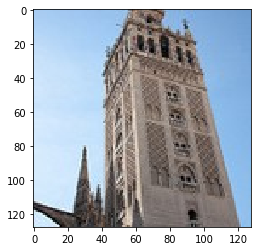

In [9]:
print(labels[2000])
plt.imshow(images[2000])

8


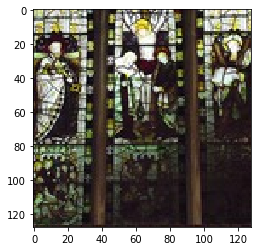

In [10]:
print(labels[9000])
plt.imshow(images[9000])

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.1, random_state=10)

In [12]:
Y_train_req = to_categorical(Y_train)
Y_test_req = to_categorical(Y_test)

print(X_train.shape, X_test.shape, Y_train_req.shape, Y_test_req.shape)

(9211, 128, 128, 3) (1024, 128, 128, 3) (9211, 10) (1024, 10)


In [13]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augmentor = ImageDataGenerator(height_shift_range=0.1, width_shift_range=0.1, horizontal_flip=True, validation_split=0.05)

# train_batches = augmentor.flow(X_train, Y_train_req, shuffle=True, subset='training')
# val_batches = augmentor.flow(X_train, Y_train_req, subset='validation')

In [14]:
del images
del labels

In [15]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dense, AveragePooling2D, GlobalAveragePooling2D, concatenate, MaxPooling2D, ZeroPadding2D, Input
from tensorflow.keras.models import Model

In [16]:
def dense_layer(inputs, growth_rate):
    
    growth_rate = int(growth_rate)
    
    batch_1 = BatchNormalization(epsilon=1.1e-5, axis=3)(inputs)
    act_1 = Activation('relu')(batch_1)
    conv_1 = Conv2D(growth_rate*4, (1,1), padding='same', strides=1, kernel_initializer='he_normal')(act_1)
    
    batch_2 = BatchNormalization(epsilon=1.1e-5, axis=3)(conv_1)
    act_2 = Activation('relu')(batch_2)
    conv_2 = Conv2D(growth_rate, (3,3), padding='same', strides=1, kernel_initializer='he_normal')(act_2)
    
    output = concatenate([inputs, conv_2], axis=3)
    
    return output

In [17]:
def transition_layer(inputs, compression_factor):
    
    comp_fact = compression_factor
    
    input_features = inputs.shape[3]
    
    new_features = int(input_features * comp_fact)
    
    batch_1 = BatchNormalization(epsilon=1.1e-5, axis=3)(inputs)
    act_1 = Activation('relu')(batch_1)
    conv_1 = Conv2D(new_features, (1,1), strides=1, padding='same', kernel_initializer='he_normal')(act_1)
    avg_1 = AveragePooling2D((2,2), strides=2)(conv_1)
    
    return avg_1

In [18]:
def DenseNet121(input_shape, classes):
    
    inputs = Input((input_shape))
    
    zero_pad = ZeroPadding2D((3,3))(inputs)
    
    conv_1 = Conv2D(64, (7,7), strides=2, kernel_initializer='he_normal')(zero_pad)
    conv_1 = BatchNormalization(epsilon=1.1e-5, axis=3)(conv_1)
    conv_1 = Activation('relu')(conv_1)
    conv_1 = ZeroPadding2D((1,1))(conv_1)
    conv_1 = MaxPooling2D((3,3), strides=2)(conv_1)
    
    dense_block_1 = dense_layer(conv_1, growth_rate=32)
    dense_block_1 = dense_layer(dense_block_1, growth_rate=32)
    dense_block_1 = dense_layer(dense_block_1, growth_rate=32)
    dense_block_1 = dense_layer(dense_block_1, growth_rate=32)
    dense_block_1 = dense_layer(dense_block_1, growth_rate=32)
    dense_block_1 = dense_layer(dense_block_1, growth_rate=32)
    
    transition_1 = transition_layer(dense_block_1, compression_factor=0.5)
    
    dense_block_2 = dense_layer(transition_1, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    dense_block_2 = dense_layer(dense_block_2, growth_rate=32)
    
    transition_2 = transition_layer(dense_block_2, compression_factor=0.5)
    
    dense_block_3 = dense_layer(transition_2, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    dense_block_3 = dense_layer(dense_block_3, growth_rate=32)
    
    transition_3 = transition_layer(dense_block_3, compression_factor=0.5)
    
    dense_block_4 = dense_layer(transition_3, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    dense_block_4 = dense_layer(dense_block_4, growth_rate=32)
    
    batch = BatchNormalization(epsilon=1.1e-5, axis=3)(dense_block_4)
    act = Activation('relu')(batch)
    
    global_pool = GlobalAveragePooling2D()(act)
    dense = Dense(classes, activation='softmax')(global_pool)
    
    model = Model(inputs = inputs, outputs=dense)
    
    return model

In [19]:
model = DenseNet121(input_shape=(128, 128, 3), classes=10)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint(save_best_only=True, monitor='val_accuracy', mode='max', patience=15, filepath='E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/Architectural Heritage Elements/architectural_heritage_elements_densenet121.h5')

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
history = model.fit(X_train, Y_train_req, epochs=50, validation_split=0.05, batch_size=64, callbacks=[cp])

Train on 8750 samples, validate on 461 samples
Epoch 1/50
8750/8750 [==============================] - 121s 14ms/sample - loss: 1.1940 - accuracy: 0.5784 - val_loss: 4.0304 - val_accuracy: 0.2668
Epoch 2/50
8750/8750 [==============================] - 99s 11ms/sample - loss: 0.8272 - accuracy: 0.7165 - val_loss: 1.3994 - val_accuracy: 0.5683
Epoch 3/50
8750/8750 [==============================] - 697s 80ms/sample - loss: 0.6616 - accuracy: 0.7739 - val_loss: 0.8731 - val_accuracy: 0.7028
Epoch 4/50
8750/8750 [==============================] - 706s 81ms/sample - loss: 0.5000 - accuracy: 0.8291 - val_loss: 0.9395 - val_accuracy: 0.7050
Epoch 5/50
8750/8750 [==============================] - 697s 80ms/sample - loss: 0.4158 - accuracy: 0.8542 - val_loss: 1.2228 - val_accuracy: 0.6681
Epoch 6/50
8750/8750 [==============================] - 701s 80ms/sample - loss: 0.3440 - accuracy: 0.8841 - val_loss: 1.0560 - val_accuracy: 0.7115
Epoch 7/50
8750/8750 [==============================] - 705s

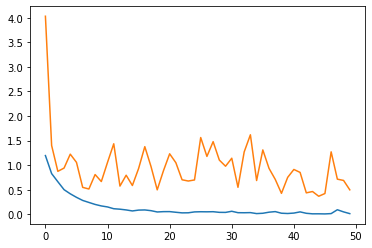

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

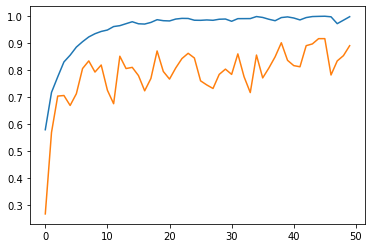

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [28]:
model.evaluate(X_test, Y_test_req)

1024/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.642284816596657, 0.875]

In [29]:
from tensorflow.keras.models import load_model

model_new = load_model('E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/Architectural Heritage Elements/architectural_heritage_elements_densenet121.h5')

In [30]:
predictions = []

for i in range(len(X_test)):
    image = X_test[i].reshape((1, 128, 128, 3))
    pred = model_new.predict(image)
    i = np.argmax(pred)
    predictions.append(i)

In [31]:
predictions

[4,
 2,
 1,
 3,
 9,
 0,
 1,
 9,
 5,
 3,
 5,
 2,
 4,
 9,
 4,
 8,
 7,
 7,
 8,
 2,
 0,
 5,
 4,
 2,
 0,
 2,
 3,
 2,
 2,
 0,
 1,
 9,
 8,
 7,
 8,
 0,
 3,
 7,
 4,
 4,
 1,
 5,
 2,
 7,
 0,
 2,
 9,
 7,
 0,
 9,
 3,
 3,
 5,
 5,
 9,
 3,
 3,
 5,
 2,
 3,
 3,
 4,
 7,
 9,
 8,
 0,
 0,
 4,
 5,
 9,
 9,
 5,
 7,
 7,
 0,
 7,
 4,
 2,
 3,
 1,
 1,
 9,
 7,
 2,
 3,
 8,
 5,
 3,
 3,
 2,
 5,
 7,
 2,
 2,
 3,
 0,
 9,
 1,
 7,
 0,
 0,
 2,
 6,
 3,
 2,
 2,
 3,
 5,
 9,
 4,
 3,
 3,
 0,
 0,
 4,
 5,
 3,
 8,
 3,
 8,
 7,
 5,
 5,
 9,
 3,
 8,
 8,
 3,
 8,
 3,
 7,
 5,
 0,
 0,
 3,
 3,
 9,
 2,
 3,
 1,
 3,
 3,
 3,
 3,
 6,
 5,
 9,
 2,
 7,
 1,
 3,
 8,
 3,
 3,
 3,
 9,
 0,
 9,
 5,
 7,
 0,
 8,
 9,
 3,
 7,
 4,
 9,
 3,
 4,
 2,
 9,
 9,
 4,
 9,
 3,
 5,
 8,
 3,
 5,
 5,
 0,
 9,
 7,
 5,
 7,
 2,
 9,
 1,
 3,
 8,
 8,
 1,
 5,
 1,
 7,
 3,
 0,
 7,
 3,
 1,
 3,
 2,
 7,
 7,
 2,
 3,
 5,
 3,
 5,
 0,
 8,
 9,
 6,
 0,
 7,
 5,
 9,
 3,
 4,
 2,
 9,
 7,
 9,
 4,
 3,
 7,
 5,
 5,
 0,
 0,
 3,
 2,
 9,
 5,
 7,
 2,
 7,
 3,
 2,
 4,
 3,
 7,
 7,
 6,
 8,
 4,
 8,
 6,
 4,
 2,


In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy_score(Y_test, predictions)

0.9052734375

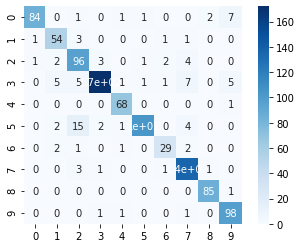

In [34]:
cm = confusion_matrix(Y_test, predictions)
hm = sns.heatmap(cm, square=True, annot=True, cmap='Blues')

plt.show(hm)